In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import yaml

In [3]:
with open("data/swiss-reviews-helpful-correct.txt", 'r') as fp:
    s_swiss_rev_help = fp.readlines()

In [4]:
len(s_swiss_rev_help)

10729

In [5]:
s_swiss_rev_help[0]

'{"reviewerID": "A08719731S0E5PHVCG6EZ", "asin": "B005WFPLWA", "reviewerName": "Sophie Clouet", "helpful": [0, 10], "reviewText": "JE NE VOIS PAS ENCORE D\'AM&Eacute;LIORATION CONTRE LA PERTE DES CHEVEUX.  JE VERRAI APR&Egrave;S LE TRAITEMENT SI C\'EST BON OU NON", "overall": 1.0, "summary": "COMMENTAIRE", "unixReviewTime": 1356739200, "reviewTime": "12 29, 2012"}\n'

In [7]:
# Below to ARI score

In [8]:
import re
import nltk.data
from nltk import wordpunct_tokenize

s_text = '''There are two ways of constructing a software design:
One way is to make it so simple that there are obviously no deficiencies and
the other way is to make it so complicated that there are no obvious deficiencies.'''
# — C.A.R. Hoare, The 1980 ACM Turing Award Lecture

# split into words by punctuations
# remove punctuations and all '-' words
RE = re.compile('[0-9a-z-]', re.I)
s_sent = nltk.data.load('tokenizers/punkt/english.pickle')

In [9]:
def get_ARI_score(text):
    words = list(filter(lambda w: RE.search(w) and w.replace('-', ''), wordpunct_tokenize(text)))
    wordc = len(words)
    charc = sum(len(w) for w in words)
    sents = s_sent.tokenize(text)
    sentc = len(sents)
    return 4.71 * charc / (wordc + 0.1) + 0.5 * (wordc + 0.1) / (sentc + 0.1) - 21.43

In [10]:
# Create the feature dictionary:

In [11]:
def convert_to_dict(line):
    l = line.rstrip('\n')
    l = eval(l)
    return l

In [12]:
s_dict_list = []
counter = 1
for item in s_swiss_rev_help:
    if(counter%500 == 0):
        print(counter)
    counter += 1
    s_dict_list.append(convert_to_dict(item))

500
1000
1500
2000
2500
3000
3500
4000
4500
5000
5500
6000
6500
7000
7500
8000
8500
9000
9500
10000
10500


In [13]:
s_features = pd.DataFrame(s_dict_list)

In [14]:
s_features.drop(['reviewTime', 'reviewerName', 'unixReviewTime'],inplace=True,axis=1)

In [15]:
s_features.head(3)

,asin,helpful,overall,reviewText,reviewerID,summary
0,B005WFPLWA,"[0, 10]",1.0,JE NE VOIS PAS ENCORE D'AM&Eacute;LIORATION CO...,A08719731S0E5PHVCG6EZ,COMMENTAIRE
1,B00064FXH0,"[17, 20]",1.0,I ordered this thinking it would speed up my r...,A1006UA0557GXP,Great idea...next year when the bugs are worke...
2,B003VAHYTG,"[162, 174]",5.0,I mainly got this set for music and some games...,A100JEV1I8ZHJ8,Quality 2.1 System for Music and Games


In [16]:
# Review length
s_features["rev_length"] = s_features['reviewText'].apply(lambda x: len(x))
s_features["rev_length"] = (s_features["rev_length"] - \
                          s_features["rev_length"].mean()) / s_features["rev_length"].std()

In [17]:
# Number of all caps
def count_all_caps(text):
    count = 0
    for i in text:
        if(i.isupper()):
            count += 1
    return count/(len(text) + 1)

In [18]:
s_features["all_caps"] = s_features['reviewText'].apply(count_all_caps)
s_features["all_caps"] = (s_features["all_caps"] - \
                          s_features["all_caps"].mean()) / s_features["all_caps"].std()

In [19]:
# Sentence count
s_features["sent_count"] = s_features['reviewText'].apply(lambda x: \
                                                      len(nltk.tokenize.sent_tokenize(x)))

In [20]:
s_features["sent_count"] = (s_features["sent_count"] - \
                          s_features["sent_count"].mean()) / s_features["sent_count"].std()

In [21]:
# Question and exclamation marks ratio to characters
def count_ques_exc_ratio(text):
    count = 0
    for i in text:
        if(i == '!' or i == '?'):
            count += 1
    return count*1.0/(len(text)+1)

In [22]:
s_features["que_exc_ratio"] = s_features['reviewText'].apply(count_ques_exc_ratio)
s_features["que_exc_ratio"] = (s_features["que_exc_ratio"] - \
                          s_features["que_exc_ratio"].mean()) / s_features["que_exc_ratio"].std()

In [23]:
# ARI readability index
s_features["ari_score"] = s_features['reviewText'].apply(get_ARI_score)

In [24]:
s_features["ari_score"] = (s_features["ari_score"] - \
                          s_features["ari_score"].mean()) / s_features["ari_score"].std()

In [25]:
# rating deviation from mean rating score
with open("data/asin_ratings_small.json", "r") as fp:
    s_asin_rev_ratings = fp.readlines()

In [26]:
s_dict_list_ar = []
for item in s_asin_rev_ratings:
    s_dict_list_ar.append(convert_to_dict(item))

In [27]:
s_dict_ar = dict([(key,d[key]) for d in s_dict_list_ar for key in d])

In [34]:
def get_dev_mean_score(row):
    if(row['asin'] in s_dict_ar.keys()):
        return row['overall'] - s_dict_ar[row['asin']]
    print("Should not get here")
    return 0

In [35]:
s_features['dev_mean_score'] = s_features.apply(get_dev_mean_score, axis=1)

In [36]:
# should only be standardized after dev_mean_score has been computed
s_features["overall"] = (s_features["overall"] - \
                          s_features["overall"].mean()) / s_features["overall"].std()

In [37]:
s_features["dev_mean_score"] = (s_features["dev_mean_score"] - \
                          s_features["dev_mean_score"].mean()) / s_features["dev_mean_score"].std()

In [38]:
len(s_features)

10729

In [39]:
s_features.drop_duplicates(subset=['asin','reviewText'], keep='first', inplace=True)

In [41]:
len(s_features)

10693

In [42]:
def create_labels(pair):
    if(pair[0]*1.0/pair[1] >= 0.6):
        return 1
    else:
        return 0

In [43]:
s_features['Y'] = s_features['helpful'].apply(create_labels)

In [102]:
from sklearn.feature_extraction.text import CountVectorizer
s_count_vect = CountVectorizer(stop_words='english')
s_X_train_counts = s_count_vect.fit_transform(list(s_features['reviewText']))

In [47]:
s_X_train_counts.shape

(10693, 36391)

In [48]:
from sklearn.feature_extraction.text import TfidfTransformer
s_tf_transformer = TfidfTransformer().fit(s_X_train_counts)
s_X_train_tf = s_tf_transformer.transform(s_X_train_counts)

In [49]:
s_X_train_tf.shape

(10693, 36391)

In [50]:
from sklearn.preprocessing import scale, MaxAbsScaler, maxabs_scale

In [51]:
maxabs_scale(s_X_train_tf, copy=False)

<10693x36391 sparse matrix of type '<class 'numpy.float64'>'
	with 737288 stored elements in Compressed Sparse Row format>

In [52]:
s_Y = s_features.as_matrix(['Y'])

In [53]:
s_Y.shape

(10693, 1)

In [54]:
s_X_train_else = s_features.as_matrix(['overall','rev_length','all_caps','sent_count','que_exc_ratio',
                                   'ari_score', 'dev_mean_score'])

In [55]:
type(s_X_train_else)

numpy.ndarray

In [56]:
from scipy.sparse import hstack
s_X = hstack([s_X_train_tf, s_X_train_else])

In [57]:
type(s_X)

scipy.sparse.coo.coo_matrix

In [58]:
s_X.shape

(10693, 36398)

In [59]:
s_Y.shape

(10693, 1)

In [61]:
s_Y = s_Y.reshape((s_Y.shape[0],))

In [62]:
s_Y.shape

(10693,)

In [63]:
# Time for some machine learning

In [64]:
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn import preprocessing
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict
from sklearn.metrics import confusion_matrix, roc_curve

In [66]:
s_cllr = LogisticRegression(class_weight='balanced', n_jobs=-1, C=1e2)

In [82]:
x_tr, x_te, y_tr, y_te = train_test_split(s_X, s_Y, train_size=0.8)

In [83]:
s_cllr.fit(x_tr, y_tr)
print("Test set accuracy:" , s_cllr.score(x_te, y_te))
print("Train set accuracy:", s_cllr.score(x_tr, y_tr))

Test set accuracy: 0.861150070126
Train set accuracy: 0.999532382511


In [65]:
s_clrf = RandomForestClassifier(n_estimators = 10, class_weight='balanced', n_jobs=-1)

In [85]:
s_clrf.fit(x_tr, y_tr)
print("Test set accuracy:" , s_clrf.score(x_te, y_te))
print("Train set accuracy:", s_clrf.score(x_tr, y_tr))

Test set accuracy: 0.849462365591
Train set accuracy: 0.996142155717


In [67]:
s_clab = AdaBoostClassifier()

In [84]:
s_clab.fit(x_tr, y_tr)
print("Test set accuracy:" , s_clab.score(x_te, y_te))
print("Train set accuracy:", s_clab.score(x_tr, y_tr))

Test set accuracy: 0.847124824684
Train set accuracy: 0.849777881693


In [68]:
# C could be tuned
s_clsvc = SVC(class_weight='balanced', kernel='linear', probability=True)

In [86]:
s_clsvc.fit(x_tr, y_tr)
print("Test set accuracy:" , s_clsvc.score(x_te, y_te))
print("Train set accuracy:", s_clsvc.score(x_tr, y_tr))

Test set accuracy: 0.859280037401
Train set accuracy: 0.999064765022


In [284]:
clrf.fit(x_tr, y_tr)
print("Test set accuracy:" , clsf.score(x_te, y_te))
print("Train set accuracy:", clsf.score(x_tr, y_tr))

Test set accuracy: 0.855072463768
Train set accuracy: 0.995206920739


In [285]:
acc = cross_val_score(clrf, X, Y, cv=10, n_jobs=-1)

In [286]:
acc

array([ 0.79345794,  0.79813084,  0.84205607,  0.81869159,  0.797942  ,
        0.78110384,  0.80636109,  0.80449018,  0.79232928,  0.80898876])

In [287]:
print("Bias: ", 1 - np.mean(acc))
print("variance: ", np.std(acc)**2)

Bias:  0.195644840756
variance:  0.000253627037173


In [288]:
f1s = cross_val_score(clsf, X, Y, cv=10, scoring='f1', n_jobs=-1)

In [289]:
f1s

array([ 0.87335244,  0.87586207,  0.90134267,  0.88850575,  0.87485516,
        0.86597938,  0.87802004,  0.87981599,  0.87152778,  0.88221709])

In [290]:
roc_aucs = cross_val_score(clsf, X, Y, cv=10, scoring='roc_auc', n_jobs=-1)

In [291]:
roc_aucs

array([ 0.8120666 ,  0.78800381,  0.84116938,  0.80727228,  0.75824864,
        0.7543183 ,  0.7792544 ,  0.7829971 ,  0.77979197,  0.81650301])

In [292]:
# Predict values

In [70]:
s_y_pred_rf = cross_val_predict(s_clrf, s_X, s_Y, cv=10, n_jobs=-1)

In [71]:
s_y_pred_lr = cross_val_predict(s_cllr, s_X, s_Y, cv=10, n_jobs=-1)

In [73]:
s_y_pred_ab = cross_val_predict(s_clab, s_X, s_Y, cv=10, n_jobs=-1)

In [74]:
s_y_pred_svc = cross_val_predict(s_clsvc, s_X, s_Y, cv=10, n_jobs=-1)

In [76]:
s_cm = confusion_matrix(s_Y, s_y_pred_svc)

In [77]:
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[1310 1059]
 [ 844 7480]]


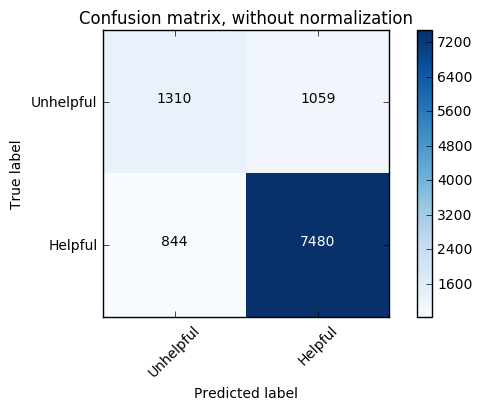

In [78]:
# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(s_cm, classes=['Unhelpful', 'Helpful'],
                      title='Confusion matrix, without normalization')
plt.show()

In [79]:
# plot roc-curve

In [88]:
s_y_pred_lr2 = s_cllr.predict_proba(s_X)[:, 1]

In [89]:
s_y_pred_rf2 = s_clrf.predict_proba(s_X)[:, 1]

In [90]:
s_y_pred_ab2 = s_clab.predict_proba(s_X)[:, 1]

In [91]:
s_y_pred_svc2 = s_clsvc.predict_proba(s_X)[:, 1]

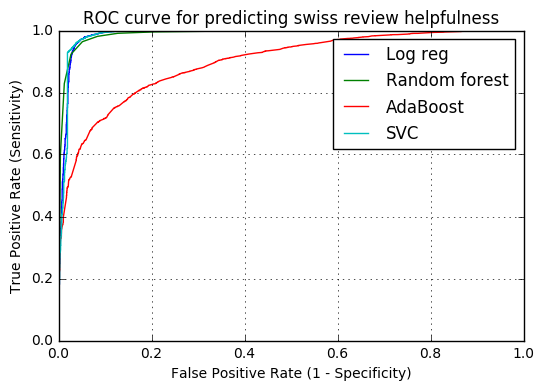

In [92]:
# IMPORTANT: first argument is true values, second argument is predicted probabilities
s_fpr_lr, s_tpr_lr, thresholds = roc_curve(s_Y, s_y_pred_lr2)
s_fpr_rf, s_tpr_rf, thresholds = roc_curve(s_Y, s_y_pred_rf2)
s_fpr_ab, s_tpr_ab, thresholds = roc_curve(s_Y, s_y_pred_ab2)
s_fpr_svc, s_tpr_svc, thresholds = roc_curve(s_Y, s_y_pred_svc2)
plt.plot(s_fpr_lr, s_tpr_lr)
plt.plot(s_fpr_rf, s_tpr_rf)
plt.plot(s_fpr_ab, s_tpr_ab)
plt.plot(s_fpr_svc, s_tpr_svc)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.title('ROC curve for predicting swiss review helpfulness')
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.legend(['Log reg', 'Random forest', 'AdaBoost', 'SVC'], loc='upper right')
plt.grid(True)

In [93]:
# feature importance

In [94]:
s_words_list = s_count_vect.get_feature_names()
s_other_feats = ['overall','rev_length','all_caps','sent_count','que_exc_ratio',
                                   'ari_score', 'dev_mean_score']
s_feature_names = s_words_list + s_other_feats

In [99]:
s_feature_names[10]

'000305'

In [95]:
len(s_feature_names)

36398

In [96]:
s_X.shape[1]

36398

In [118]:
number = 10
importances = s_clrf.feature_importances_
#std = np.std([tree.feature_importances_ for tree in clsf.estimators_], axis=0)
indices = np.argsort(importances)[::-1]

temp_names = []
for i in range(number):
    temp_names.append(s_feature_names[indices[i]])

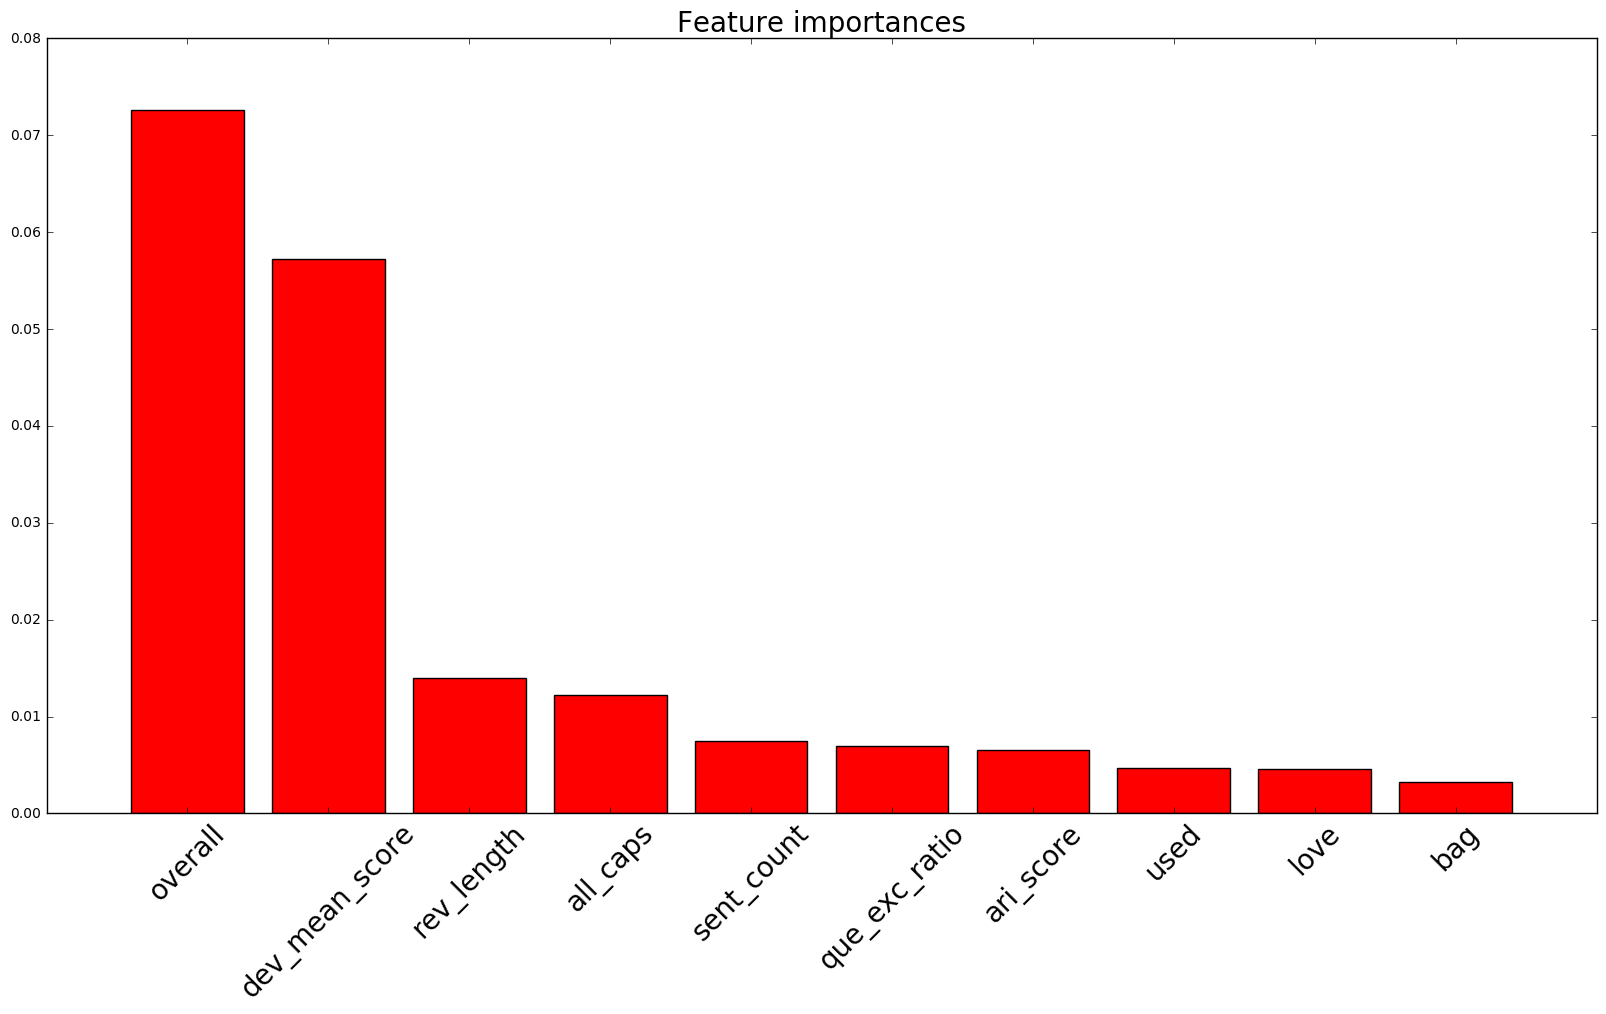

Feature ranking:
1. feature overall (0.072625)
2. feature dev_mean_score (0.057283)
3. feature rev_length (0.013988)
4. feature all_caps (0.012193)
5. feature sent_count (0.007487)
6. feature que_exc_ratio (0.006943)
7. feature ari_score (0.006570)
8. feature used (0.004653)
9. feature love (0.004637)
10. feature bag (0.003273)


In [120]:

#Plot the feature importances of the forest
plt.figure(figsize=(20,10))
plt.title("Feature importances", fontsize=20)
plt.bar(range(number), importances[indices[:number]],
       color="r", align="center")#, yerr=std[indices])
plt.xticks(range(number), temp_names, fontsize=20, rotation=45)
plt.xlim([-1, number])
plt.show()

# Print the feature ranking
print("Feature ranking:")

for f in range(number):
    print("%d. feature %s (%f)" % (f + 1,  s_feature_names[indices[f]], importances[indices[f]]))


In [106]:
importances[len(importances)-6:]

array([ 0.01398794,  0.01219323,  0.00748682,  0.00694306,  0.00657042,
        0.0572833 ])

In [111]:
s_cllr.coef_

array([[ 1.05951165, -0.04377403, -0.42685999, ..., -0.32257477,
        -0.40363764,  3.71442716]])